In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,DotProduct
import pandas as pd
import torch



In [2]:
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.learning.pytorch import LSTM
from snorkel.annotations import load_marginals

from scipy import vstack
session = SnorkelSession()

In [3]:
ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()
test = session.query(ChemicalDisease).filter(ChemicalDisease.split == 2).all()

print('Training set:\t{0} candidates'.format(len(train)))
print('Dev set:\t{0} candidates'.format(len(dev)))
print('Test set:\t{0} candidates'.format(len(test)))

Training set:	8433 candidates
Dev set:	920 candidates
Test set:	4683 candidates


In [4]:
train_marginals = load_marginals(session, split=0)

In [5]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=2, annotator='gold')
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_dev = load_gold_labels(session,annotator_name='gold',split=1)

AnnotatorLabels created: 0


In [6]:
L_gold_dev.shape

(920, 1)

In [7]:
dev_labels = L_gold_dev.toarray().reshape(920,)
dev_labels[dev_labels == -1] = 0

In [8]:
full_train_set = train.copy()
full_train_set.extend(dev)
full_train_labels = list(train_marginals).copy()
full_train_labels.extend(dev_labels)
full_train_labels = np.array(full_train_labels)


In [9]:
len(full_train_set)
# why is it dropping so many data points?

9353

In [11]:
train_kwargs = {
    'lr':              0.01,
    'embedding_dim':   100,
    'hidden_dim':      100,
    'n_epochs':        20,
    'dropout':         0.5,
    'rebalance':       False,
    'print_freq':      5,
    'seed':            1701,
    'num_layers':      5,
}

lstm = LSTM(n_threads=None)
lstm.train(full_train_set, full_train_labels, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=8573  #epochs=20  batch size=64
[LSTM] Epoch 1 (92.82s)	Average loss=0.687648	Dev F1=50.00


KeyboardInterrupt: 

In [ ]:
lstm.save('trained_on_all_5_layers')

In [ ]:
lstm.score(test, L_gold_test)

In [61]:
dev_features = lstm.feature_outputs(dev, 100)
train_features = lstm.feature_outputs(train, 100)

In [62]:
kernel_dev = RBF(1) + WhiteKernel(1)
kernel_train = RBF(1) + WhiteKernel(1)
gpc_dev = GaussianProcessClassifier(kernel = kernel_dev)
gpc_train = GaussianProcessClassifier(kernel = kernel_train)

In [63]:
train_labels = train_marginals.copy()
train_labels[train_labels > .5] = 1
train_labels[train_labels <= .5] = 0

In [64]:
gpc_dev.fit(dev_features.detach().numpy().reshape(920,10), dev_labels.reshape(920,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [65]:
gpc_train.fit(train_features.detach().numpy().reshape(8433,10), train_labels.reshape(8433,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [66]:
test_features = lstm.feature_outputs(test,100)

In [67]:
gpc_dev.kernel_

RBF(length_scale=2.66) + WhiteKernel(noise_level=1e-05)

In [68]:
gpc_train.kernel_

RBF(length_scale=3.15) + WhiteKernel(noise_level=1e-05)

In [72]:
ud = []
ut = []
preds_d = gpc_dev.predict_proba(test_features.detach().numpy().reshape(4683,10), uncertainty = ud)
preds_t = gpc_train.predict_proba(test_features.detach().numpy().reshape(4683,10), uncertainty = ut)

In [73]:
ud = ud[0]
ut = ut[0]

In [74]:
gpc_dev.classes_

array([0, 1], dtype=int64)

In [76]:
# what is the order of the probabilties? I think I was probably doingit backwards actually. 
pd, pt = [],[]
for x in preds_d:
    if x[0] > .5:
        pd.append(0)
    else:
        pd.append(1)
for x in preds_t:
    if x[0] > .5:
        pt.append(0)
    else:
        pt.append(1) 

In [77]:
ud = np.array(ud)
ut = np.array(ut)

In [78]:
ud.mean()

0.073703029154715605

In [79]:
ud.max()

0.72773439191896705

In [80]:
ut.mean()

0.024862654367269314

In [81]:
ut.max()

0.23736542296623175

In [84]:
test_y = L_gold_test.toarray().reshape(4683,)
test_y[test_y == -1] = 0

In [86]:
buckets = np.linspace(0,.4,15)

In [89]:
f1scores = []
for i in range(14):
    count = 0
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_y):
        if ud[j] >= buckets[i] and ud[j] < buckets[i+1]:
            count += 1
            if p == 0 and pd[j] == 0:
                tn += 1
            elif p == 0 and pd[j] == 1:
                fp += 1
            elif p == 1 and pd[j] == 0:
                fn += 1
            else: #p == 1 and preds[j] == 1:
                tp += 1
    try:
        p = tp / (tp + fp)
    except:
        p = 0
    try:
        r = tp / (tp + fn)
    except: 
        r = 0
    try:
        f1 = 2/(1/p + 1/r)
    except:
        f1 = 0
    f1scores.append(f1)
    print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

Bucket 0.028571428571428574: 
 Count: 65
 F1: 0
0,0,45,20
Bucket 0.05714285714285715: 
 Count: 2270
 F1: 0.2711864406779661
128,116,1454,572
Bucket 0.08571428571428572: 
 Count: 1400
 F1: 0.5136094674556213
217,132,772,279
Bucket 0.1142857142857143: 
 Count: 445
 F1: 0.5693430656934306
78,39,249,79
Bucket 0.14285714285714288: 
 Count: 183
 F1: 0.6324786324786325
37,10,103,33
Bucket 0.17142857142857143: 
 Count: 92
 F1: 0.44999999999999996
9,7,61,15
Bucket 0.2: 
 Count: 46
 F1: 0
0,0,32,14
Bucket 0.2285714285714286: 
 Count: 45
 F1: 0
0,1,38,6
Bucket 0.2571428571428572: 
 Count: 33
 F1: 0
0,0,28,5
Bucket 0.28571428571428575: 
 Count: 20
 F1: 0.6
3,0,13,4
Bucket 0.31428571428571433: 
 Count: 17
 F1: 0.4444444444444444
2,0,10,5
Bucket 0.34285714285714286: 
 Count: 10
 F1: 0
0,0,10,0
Bucket 0.37142857142857144: 
 Count: 7
 F1: 0
0,0,7,0
Bucket 0.4: 
 Count: 16
 F1: 0
0,0,13,3


<BarContainer object of 14 artists>

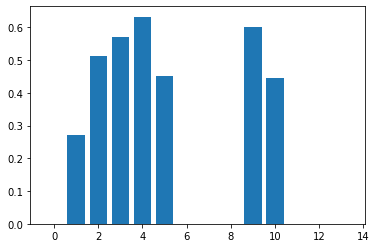

In [90]:
plt.bar(np.arange(len(f1scores)),f1scores)

In [91]:
f1scores = []
for i in range(14):
    count = 0
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_y):
        if ut[j] >= buckets[i] and ut[j] < buckets[i+1]:
            count += 1
            if p == 0 and pt[j] == 0:
                tn += 1
            elif p == 0 and pt[j] == 1:
                fp += 1
            elif p == 1 and pt[j] == 0:
                fn += 1
            else: #p == 1 and preds[j] == 1:
                tp += 1
    try:
        p = tp / (tp + fp)
    except:
        p = 0
    try:
        r = tp / (tp + fn)
    except: 
        r = 0
    try:
        f1 = 2/(1/p + 1/r)
    except:
        f1 = 0
    f1scores.append(f1)
    print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

Bucket 0.028571428571428574: 
 Count: 3581
 F1: 0.45880341880341874
671,1245,1327,338
Bucket 0.05714285714285715: 
 Count: 719
 F1: 0.6409155937052933
224,204,244,47
Bucket 0.08571428571428572: 
 Count: 212
 F1: 0.8131868131868131
111,39,50,12
Bucket 0.1142857142857143: 
 Count: 74
 F1: 0.8173913043478261
47,18,6,3
Bucket 0.14285714285714288: 
 Count: 48
 F1: 0.8059701492537313
27,13,8,0
Bucket 0.17142857142857143: 
 Count: 24
 F1: 0.8292682926829269
17,7,0,0
Bucket 0.2: 
 Count: 15
 F1: 0.8695652173913044
10,3,2,0
Bucket 0.2285714285714286: 
 Count: 9
 F1: 0.875
7,2,0,0
Bucket 0.2571428571428572: 
 Count: 1
 F1: 0
0,1,0,0
Bucket 0.28571428571428575: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.31428571428571433: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.34285714285714286: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.37142857142857144: 
 Count: 0
 F1: 0
0,0,0,0
Bucket 0.4: 
 Count: 0
 F1: 0
0,0,0,0


<BarContainer object of 14 artists>

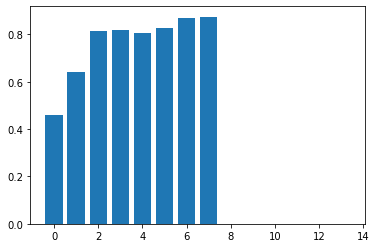

In [92]:
plt.bar(np.arange(len(f1scores)),f1scores)

In [99]:
tp,fp,tn,fn = 0,0,0,0
for j,p in enumerate (test_y):
        if p == 0 and pt[j] == 0:
            tn += 1
        elif p == 0 and pt[j] == 1:
            fp += 1
        elif p == 1 and pt[j] == 0:
            fn += 1
        else: #p == 1 and preds[j] == 1:
            tp += 1
try:
    p = tp / (tp + fp)
except:
    p = 0
try:
    r = tp / (tp + fn)
except: 
    r = 0
try:
    f1 = 2/(1/p + 1/r)
except:
    f1 = 0

In [100]:
f1

0.5355769230769231

In [98]:
p

0.6084724005134788

In [105]:
dev_cov= np.matmul(dev_features.detach().numpy().reshape(920,10).transpose(), dev_features.detach().numpy().reshape(920,10))

In [107]:
np.linalg.svd(dev_cov)

(array([[-0.01717199,  0.07703116,  0.43671137, -0.61601961, -0.48060361,
         -0.17902957,  0.38620245, -0.08416685, -0.06293064, -0.01860882],
        [ 0.01309415,  0.22883707,  0.40875095,  0.704216  , -0.20644875,
          0.10895157,  0.43903291,  0.13135228,  0.04461711, -0.13408597],
        [ 0.01057392,  0.08229483,  0.1025309 ,  0.17876582, -0.07995219,
          0.04806772, -0.12696463, -0.49210468, -0.7120055 ,  0.420362  ],
        [-0.0099605 ,  0.07100091, -0.18645364, -0.02865227,  0.10208215,
         -0.2449479 ,  0.29883894,  0.6436125 , -0.20650625,  0.58537757],
        [ 0.04671174, -0.28572264, -0.00227666, -0.03158083,  0.547005  ,
         -0.26249269,  0.46487954, -0.10950558, -0.37582809, -0.42155659],
        [ 0.02259071, -0.22625703,  0.76086962, -0.04627996,  0.3399525 ,
         -0.00306356, -0.4053776 ,  0.27634951, -0.02494574,  0.10165408],
        [-0.99639952, -0.06901168,  0.01313602,  0.03268808,  0.00867838,
         -0.01276441,  0.0061765

In [114]:
gpc_dev.score(dev_features.detach().numpy().reshape(920,10), dev_labels)

0.70652173913043481

In [115]:
gpc_train.score(train_features.detach().numpy().reshape(8433,10), train_labels)

0.80434009249377447

In [116]:
gpc_dev.kernel_

RBF(length_scale=2.66) + WhiteKernel(noise_level=1e-05)

In [117]:
gpc_train.kernel_

RBF(length_scale=3.15) + WhiteKernel(noise_level=1e-05)